# RHF Hessian

## 二阶梯度问题导言

我们在上一章，已经对一阶梯度的问题有比较深入的了解。pyxdh 的目标是解决 XYG3 型泛函的二阶梯度的计算；因此，我们不能止步于此。这一章，我们最后会讨论到 XYG3 的二阶梯度计算，完成这份文档的目标。

上一章我们主要使用的是核坐标 $\mathbb{A} = A_t$ 来讨论梯度计算；在二阶梯度中，我们仍然使用核坐标讨论。因此，我们会引入第二个原子核坐标分量 $B_s$ 来作为被求导量。但从程序的实现角度上来说，如果我们有 Skeleton 导数 $(\mu \nu | \kappa \lambda)^{A_t B_s}$，那么它的维度将是 $(A, t, B, s, \mu, \nu, \kappa, \lambda)$，即八维张量。这多少有些冗长；而且我们还需要考虑到我们还会求取核坐标与电场的混合梯度，因此我们希望对被求导量的维度作重新规划。

在以后的文段中，我们会沿用 pyxdh 的程序习惯，将 $(\mu \nu | \kappa \lambda)^{A_t B_s}$ 的维度定义为 $(A, t, B, s, \mu, \nu, \kappa, \lambda)$。其余类推。

我们希望通过几篇文档，能较好地描述二阶梯度问题；但使用核坐标二维梯度，就意味着被求导量是相同的，在理解导数的过程中可能会忽视了被求导量对称性的问题，因此最好的方式应当是用使用混合导数来引导我们的二阶梯度计算。但正因为电场有许多 Skeleton 导数恰好为零，因此混合核坐标与电场梯度中也会存在很多零项，影响讨论。因此，我们最终选择用核坐标二阶梯度来引导我们的讨论。

我们由于在一阶梯度时，已经讨论了许多推导的方式；因此在二阶梯度文档中，公式的推导速度略过许多细节，也不会用很多习题来引导思考。

## 准备工作

我们会使用 `HessSCF` 类作为求取 RHF (或 GGA) Hessian 的计算实例。它的初始化需要 `GradSCF` 的实例。

In [1]:
%matplotlib notebook

from pyscf import gto, scf, dft, lib, grad, hessian
import numpy as np
from functools import partial
import warnings
from matplotlib import pyplot as plt
from pyxdh.Utilities import NucCoordDerivGenerator, DipoleDerivGenerator, NumericDiff
from pyxdh.DerivOnce import GradSCF
from pyxdh.DerivTwice import HessSCF

np.einsum = partial(np.einsum, optimize=["greedy", 1024 ** 3 * 2 / 8])
np.allclose = partial(np.allclose, atol=1e-6, rtol=1e-4)
np.set_printoptions(5, linewidth=150, suppress=True)
warnings.filterwarnings("ignore")

In [2]:
mol = gto.Mole()
mol.atom = """
O  0.0  0.0  0.0
O  0.0  0.0  1.5
H  1.0  0.0  0.0
H  0.0  0.7  1.0
"""
mol.basis = "6-31G"
mol.verbose = 0
mol.build()

In [3]:
gradh = GradSCF({"scf_eng": scf.RHF(mol), "cphf_tol": 1e-12})
hessh = HessSCF({"deriv_A": gradh, "deriv_B": gradh})

In [4]:
nmo, nao, natm, nocc, nvir = gradh.nao, gradh.nao, gradh.natm, gradh.nocc, gradh.nvir
so, sv, sa = gradh.so, gradh.sv, gradh.sa
mol_slice = gradh.mol_slice
C, Co, Cv, e, eo, ev, D = gradh.C, gradh.Co, gradh.Cv, gradh.e, gradh.eo, gradh.ev, gradh.D
H_0_ao, S_0_ao, eri0_ao, F_0_ao = gradh.H_0_ao, gradh.S_0_ao, gradh.eri0_ao, gradh.F_0_ao
H_0_mo, S_0_mo, eri0_mo, F_0_mo = gradh.H_0_mo, gradh.S_0_mo, gradh.eri0_mo, gradh.F_0_mo
H_1_ao, S_1_ao, eri1_ao, F_1_ao = gradh.H_1_ao, gradh.S_1_ao, gradh.eri1_ao, gradh.F_1_ao
H_1_mo, S_1_mo, eri1_mo, F_1_mo = gradh.H_1_mo, gradh.S_1_mo, gradh.eri1_mo, gradh.F_1_mo
Ax0_Core, B_1, U_1, U_1_vo = gradh.Ax0_Core, gradh.B_1, gradh.U_1, gradh.U_1_vo

In [5]:
def grad_generator(mol):
    scf_eng = scf.RHF(mol)
    config = {"scf_eng": scf_eng, "cphf_tol": 1e-12}
    return GradSCF(config)

gradn = NucCoordDerivGenerator(mol, grad_generator)

In [6]:
def plot_diff(anal_mat, num_mat):
    fig, ax = plt.subplots(figsize=(2.4, 1.8)); ax.set_xscale("log")
    ax.hist(abs(anal_mat.ravel() - num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    ax.hist(abs(num_mat.ravel()), bins=np.logspace(np.log10(1e-10), np.log10(1e-1), 50), alpha=0.5)
    return fig.tight_layout()

我们不妨看一下通过 `hessh` 计算得到的 Hessian $\partial_{A_t} \partial_{B_s} E_\mathrm{tot}$ 是长什么样子的：

In [7]:
hessh.E_2

array([[ 0.36765, -0.01096, -0.02986, -0.02036,  0.0064 ,  0.03848, -0.4029 ,  0.00214, -0.02579,  0.0556 ,  0.00242,  0.01717],
       [-0.01096,  0.02901,  0.11159,  0.0047 ,  0.08453, -0.11579,  0.00851, -0.03718,  0.0048 , -0.00226, -0.07637, -0.0006 ],
       [-0.02986,  0.11159,  0.47024, -0.00243,  0.00961, -0.33099,  0.02687,  0.0038 , -0.03383,  0.00542, -0.125  , -0.10542],
       [-0.02036,  0.0047 , -0.00243, -0.07793, -0.00283, -0.04145, -0.00102, -0.0056 ,  0.04462,  0.09931,  0.00372, -0.00074],
       [ 0.0064 ,  0.08453,  0.00961, -0.00283,  0.66306, -0.43734,  0.00034,  0.00409, -0.00816, -0.00392, -0.75168,  0.43588],
       [ 0.03848, -0.11579, -0.33099, -0.04145, -0.43734,  0.426  , -0.00318,  0.00431, -0.04919,  0.00616,  0.54882, -0.04582],
       [-0.4029 ,  0.00851,  0.02687, -0.00102,  0.00034, -0.00318,  0.41067, -0.01219, -0.02918, -0.00675,  0.00333,  0.00549],
       [ 0.00214, -0.03718,  0.0038 , -0.0056 ,  0.00409,  0.00431, -0.01219,  0.02907,  0.00724,

它可以通过下述的数值导数方法获得；其中，`E_1` 是 $(A, t)$ 维度的分子力 $\partial_{A_t} E_\mathrm{tot}$，我们对其压平后进行数值导数，能得到与上述代码近乎一致的输出：

In [8]:
nd_E_1 = NumericDiff(gradn, lambda gradh: gradh.E_1.ravel()).derivative
nd_E_1.shape

(12, 12)

In [9]:
np.allclose(hessh.E_2, nd_E_1, atol=5e-6)

True

## RHF Hessian 概述

我们首先回顾 RHF 的能量表达式：

$$
E_\mathrm{tot} = h_{\mu \nu} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda) D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda) D_{\kappa \lambda} + E_\mathrm{nuc}
$$

其一阶梯度表达式是

$$
\begin{align}
\frac{\partial E_\mathrm{tot}}{\partial B_s}
&= h_{\mu \nu}^{B_s} D_{\mu \nu} + \frac{1}{2} D_{\mu \nu} (\mu \nu | \kappa \lambda)^{B_s} D_{\kappa \lambda} - \frac{1}{4} D_{\mu \nu} (\mu \kappa | \nu \lambda)^{B_s} D_{\kappa \lambda} - 2 F_{ij} S_{ij}^{B_s} + \partial_{B_s} E_\mathrm{nuc}
\end{align}
$$

我们定义原子核互斥能的二阶梯度为 $\partial_{A_t} \partial_{B_s} E_\mathrm{nuc}$。那么，其余的电子能量部分则有

$$
\begin{align}
\frac{\partial^2 E_\mathrm{elec}}{\partial B_s \partial A_t}
&= \partial_{A_t} h_{\mu \nu}^{B_s} \cdot D_{\mu \nu} + 4 h_{mi}^{B_s} U_{mi}^{A_t} \\
&\quad + \frac{1}{2} \partial_{A_t} (\mu \nu | \kappa \lambda)^{B_s} \cdot D_{\mu \nu} D_{\kappa \lambda} + 4 (\mu \nu | \kappa \lambda)^{B_s} D_{\mu \nu} U_{mi}^{A_t} C_{\kappa m} C_{\lambda i} \\
&\quad - \frac{1}{4} \partial_{A_t} (\mu \kappa | \nu \lambda)^{B_s} \cdot D_{\mu \nu} D_{\kappa \lambda} - 2 (\mu \kappa | \nu \lambda)^{B_s} D_{\mu \nu} U_{mi}^{A_t} C_{\kappa m} C_{\lambda i} \\
&\quad - 2 F_{ij} C_{\mu i} C_{\nu j} \cdot \partial_{A_t} S_{\mu \nu}^{B_s} - 4 F_{ij} S_{mj}^{B_s} U_{mi}^{A_t} \\
&\quad - 2 F_{ij}^{A_t} S_{ij}^{B_s} - 2 A_{ij, mk} U_{mk}^{A_t} S_{ij}^{B_s} - 4 F_{mj} U_{mi}^{A_t} S_{ij}^{B_s}
\end{align}
$$

上式是根据导数的定义直接给出的，我们甚至现在就可以验证上述导数的计算过程；譬如我们可以用下面的代码验证

$$
\frac{\partial}{\partial A_t} (- 2 F_{ij} S_{ij}^{B_s}) = - 2 F_{ij} C_{\mu i} C_{\nu j} \cdot \partial_{A_t} S_{\mu \nu}^{B_s} - 4 F_{ij} S_{mj}^{B_s} \mathscr{U}_{mi}^{A_t} - 2 F_{ij}^{A_t} S_{ij}^{B_s} - 2 A_{ij, mk} \mathscr{U}_{mk}^{A_t} S_{ij}^{B_s} - 4 F_{mj} \mathscr{U}_{mi}^{A_t} S_{ij}^{B_s}
$$

之所以上式中可以直接使用 $\mathscr{U}_{mi}^{A_t}$ 替代 $U_{mi}^{A_t}$，是因为利用了对于任何对称的 $X_{ij}$，有 $\sum_{ij} X_{ij}^{A_t} U_{ij}^\mathbb{A} = \sum_{ij} X_{ij}^{A_t} U_{ji}^\mathbb{A}$ 的结论。若对 $\mathscr{U}_{mi}^{A_t}$ 与 $U_{mi}^{A_t}$ 之间的区别，也许需要回顾一下 [RHF U 矩阵](../derivonce/grad_rhf_U.ipynb) 文档的一些段落。我们这里暂时用到了下面文段才会介绍的 $\partial_{A_t} S_{\mu \nu}^{B_s} = S_{\mu \nu}^{A_t B_s}$ `S_2_ao`：

<IPython.core.display.Javascript object>


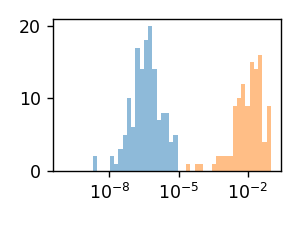

In [10]:
tmp_num = NumericDiff(gradn, lambda gradh: - 2 * np.einsum("ij, Bij -> B", gradh.F_0_mo[so, so], gradh.S_1_mo[:, so, so])).derivative
tmp_anal = (
    - 2 * np.einsum("ij, ui, vj, ABuv -> AB", F_0_mo[so, so], Co, Co, hessh.S_2_ao)
    - 4 * np.einsum("ij, Bmj, Ami -> AB", F_0_mo[so, so], S_1_mo[:, :, so], U_1[:, :, so])
    - 2 * np.einsum("Aij, Bij -> AB", F_1_mo[:, so, so], S_1_mo[:, so, so])
    - 2 * np.einsum("Aij, Bij -> AB", Ax0_Core(so, so, sa, so)(U_1[:, :, so]), S_1_mo[:, so, so])
    - 4 * np.einsum("mj, Ami, Bij -> AB", F_0_mo[:, so], U_1[:, :, so], S_1_mo[:, so, so])
)
plot_diff(tmp_num, tmp_anal)

但显然，能量导数的表达式还可以简化。首先，我们定义下述二阶 Skeleton 导数：

- `H_2_ao` $h_{\mu \nu}^{A_t B_s} = \partial_{A_t} h_{\mu \nu}^{B_s}$

- `S_2_ao` $S_{\mu \nu}^{A_t B_s} = \partial_{A_t} S_{\mu \nu}^{B_s}$

- `eri2_ao` $(\mu \nu | \kappa \lambda)^{A_t B_s} = \partial_{A_t} (\mu \nu | \kappa \lambda)^{B_s}$

经过推导，我们可以消除所有与 $U_{ij}^{A_t}$ 有关的项，得到

$$
\begin{align}
\frac{\partial^2 E_\mathrm{tot}}{\partial B_s \partial A_t}
&= h_{\mu \nu}^{A_t B_s} D_{\mu \nu} + \frac{1}{2} (\mu \nu | \kappa \lambda)^{A_t B_s} D_{\mu \nu} D_{\kappa \lambda} - \frac{1}{4} (\mu \kappa | \nu \lambda)^{A_t B_s} D_{\mu \nu} D_{\kappa \lambda} - 2 S_{ij}^{A_t B_s} F_{ij} \\
&\quad - 2 F_{ij}^{B_s} S_{ij}^{A_t} - 2 F_{ij}^{A_t} S_{ij}^{B_s} \\
&\quad + 2 (\varepsilon_i + \varepsilon_j) S_{ij}^{A_t} S_{ij}^{B_s} + 4 B_{ai}^{B_s} U_{ai}^{A_t} + S_{ij}^{A_t} A_{ij, kl} S_{kl}^{B_s} \\
&\quad + \partial_{A_t} \partial_{B_s} E_\mathrm{nuc}
\end{align}
$$

我们可以用下述的程序来验证；但下述代码中的 `H_2_ao` $h_{\mu \nu}^{A_t B_s}$, `eri2_ao` $(\mu \nu | \kappa \lambda)^{A_t B_s}$, `S_2_mo` $S_{pq}^{A_t B_s}$, `hess_nuc` $\partial_{A_t} \partial_{B_s} E_\mathrm{nuc}$ 我们需要在下文进行额外的说明。

In [11]:
np.allclose(
    + np.einsum("ABuv, uv -> AB", hessh.H_2_ao, D)
    + 0.5 * np.einsum("ABuvkl, uv, kl -> AB", hessh.eri2_ao, D, D)
    - 0.25 * np.einsum("ABukvl, uv, kl -> AB", hessh.eri2_ao, D, D)
    - 2 * np.einsum("ABij, ij -> AB", hessh.S_2_mo[:, :, so, so], F_0_mo[so, so])
    - 2 * np.einsum("Bij, Aij -> AB", F_1_mo[:, so, so], S_1_mo[:, so, so])
    - 2 * np.einsum("Aij, Bij -> AB", F_1_mo[:, so, so], S_1_mo[:, so, so])
    + 2 * np.einsum("ij, Aij, Bij -> AB", eo[:, None] + eo[None, :], S_1_mo[:, so, so], S_1_mo[:, so, so])
    + 4 * np.einsum("Bai, Aai -> AB", B_1[:, sv, so], U_1_vo)
    + np.einsum("Bij, Aij -> AB", Ax0_Core(so, so, so, so)(S_1_mo[:, so, so]), S_1_mo[:, so, so])
    + hessian.RHF(gradh.scf_eng).hess_nuc().swapaxes(1, 2).reshape((12, 12)),
    hessh.E_2
)

True

## 二阶 Skeleton 导数

### `H_2_ao` $h_{\mu \nu}^{A_t B_s}$ Hamiltonian Core 二阶导数

我们知道 Hamiltonian Core 分为两部分：动能与原子核势能部分。动能部分的一阶导数为

$$
\begin{align}
h_{\mu \nu}^{B_s} &\leftarrow \frac{\partial}{\partial B_s} \langle \mu | \hat t | \nu \rangle = - \langle \partial_s \mu_B | \hat t | \nu \rangle + \mathrm{swap} (\mu, \nu)
\end{align}
$$

由于 $\partial_{A_t} \hat t = 0$，因此推导导数的过程会相当方便。利用链式法则，得到

$$
\frac{\partial^2}{\partial A_t \partial B_s} \langle \mu | \hat t | \nu \rangle = \langle \partial_t \partial_s \mu_{AB} | \hat t | \nu \rangle + \langle \partial_t \mu_A | \hat t | \partial_s \nu_B \rangle + \mathrm{swap} (\mu, \nu)
$$

在 PySCF 中，下述积分是可以生成的：

- `int1e_ipipkin` $\langle \partial_t \partial_s \mu | \hat t | \nu \rangle$

- `int1e_ipipkin` $\langle \partial_t \mu | \hat t | \partial_s \nu \rangle$

In [12]:
int1e_ipipkin = mol.intor("int1e_ipipkin").reshape(3, 3, nao, nao)
int1e_ipipkin.shape

(3, 3, 22, 22)

In [13]:
int1e_ipkinip = mol.intor("int1e_ipkinip").reshape(3, 3, nao, nao)
int1e_ipkinip.shape

(3, 3, 22, 22)

我们的做法是，先生成一个 $(A, t, B, s, \mu, \nu)$ 维度的张量，随后将其转换为 $(A_t, B_s, \mu, \nu)$ 维度。

In [14]:
H_2_ao_contrib1 = np.zeros((natm, 3, natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    H_2_ao_contrib1[A, :, A, :, sA, :] += int1e_ipipkin[:, :, sA, :]
    for B in range(natm):
        sB = mol_slice(B)
        H_2_ao_contrib1[A, :, B, :, sA, sB] += int1e_ipkinip[:, :, sA, sB]
H_2_ao_contrib1 += H_2_ao_contrib1.swapaxes(-1, -2)
H_2_ao_contrib1.shape = (natm * 3, natm * 3, nao, nao)

In [15]:
def get_H_1_ao_contrib1(gradh):
    mol = gradh.mol
    H_1_ao_contrib1 = np.zeros((natm, 3, nao, nao))
    for A in range(natm):
        sA = mol_slice(A)
        H_1_ao_contrib1[A, :, sA, :] -= mol.intor("int1e_ipkin")[:, sA, :]
    H_1_ao_contrib1 += H_1_ao_contrib1.swapaxes(-1, -2)
    return H_1_ao_contrib1.reshape(natm * 3, nao, nao)

nd_H_1_ao_contrib1 = NumericDiff(gradn, get_H_1_ao_contrib1).derivative

<IPython.core.display.Javascript object>


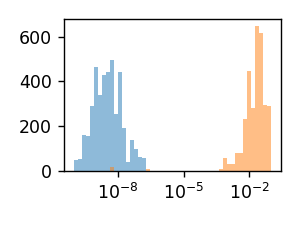

In [16]:
plot_diff(H_2_ao_contrib1, nd_H_1_ao_contrib1)

第二部分则是原子核的势能的导数。我们回顾到

$$
h_{\mu \nu}^{B_s} \leftarrow - \langle \mu | \hat v_\mathrm{nuc} | \partial_s \nu_B \rangle - \langle \mu | \frac{Z_B}{| \boldsymbol{r} - \boldsymbol{B} |} | \partial_s \nu \rangle + \mathrm{swap} (\mu, \nu)
$$

我们可以利用链式法则，并且利用到分部积分的结论，我们能推知

$$
\begin{align}
\frac{\partial^2}{\partial A_t \partial B_s} \langle \mu | \hat v_\mathrm{nuc} | \nu \rangle &= \langle \partial_t \partial_s \mu_{AB} | \hat v_\mathrm{nuc} | \nu \rangle + \langle \partial_t \mu_A | \hat v_\mathrm{nuc} | \partial_s \nu_B \rangle
+ \langle \partial_t \partial_s \mu_A | \frac{Z_B}{| \boldsymbol{r} - \boldsymbol{B} |} | \nu \rangle + \langle \partial_t \mu_A | \frac{Z_B}{| \boldsymbol{r} - \boldsymbol{B} |} | \partial_s \nu \rangle \\
&\quad + \langle \mu | \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \partial_t \partial_s \nu_B \rangle + \langle \partial_t \mu | \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \partial_s \nu_B \rangle
- \langle \partial_t \partial_s \mu | \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \nu \rangle \delta_{AB} - \langle \partial_s \mu | \frac{Z_A}{| \boldsymbol{r} - \boldsymbol{A} |} | \partial_t \nu \rangle \delta_{AB}
\end{align}
$$

上式的第一行是对左右矢直接求导得到，第二行是对算符求导后分部积分得到。

In [17]:
int1e_ipipnuc = mol.intor("int1e_ipipnuc").reshape(3, 3, nao, nao)
int1e_ipnucip = mol.intor("int1e_ipnucip").reshape(3, 3, nao, nao)

In [18]:
H_2_ao_contrib2 = np.zeros((natm, 3, natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    H_2_ao_contrib2[A, :, A, :, sA, :] += int1e_ipipnuc[:, :, sA, :]  # Term 1
    with mol.with_rinv_as_nucleus(A):
        H_2_ao_contrib2[A, :, A] += - mol.atom_charge(A) * mol.intor("int1e_ipiprinv").reshape(3, 3, nao, nao)  # Term 7
        H_2_ao_contrib2[A, :, A] += - mol.atom_charge(A) * mol.intor("int1e_iprinvip").reshape(3, 3, nao, nao)  # Term 8
    for B in range(natm):
        sB = mol_slice(B)
        H_2_ao_contrib2[A, :, B, :, sA, sB] += int1e_ipnucip[:, :, sA, sB]  # Term 2
        with mol.with_rinv_as_nucleus(B):
            H_2_ao_contrib2[A, :, B, :, sA, :] += mol.atom_charge(B) * mol.intor("int1e_ipiprinv").reshape(3, 3, nao, nao)[:, :, sA, :]  # Term 3
            H_2_ao_contrib2[A, :, B, :, sA, :] += mol.atom_charge(B) * mol.intor("int1e_iprinvip").reshape(3, 3, nao, nao)[:, :, sA, :]  # Term 4
        with mol.with_rinv_as_nucleus(A):
            H_2_ao_contrib2[A, :, B, :, :, sB] += mol.atom_charge(A) * mol.intor("int1e_ipiprinv").reshape(3, 3, nao, nao).swapaxes(-1, -2)[:, :, :, sB]  # Term 5
            H_2_ao_contrib2[A, :, B, :, :, sB] += mol.atom_charge(A) * mol.intor("int1e_iprinvip").reshape(3, 3, nao, nao)[:, :, :, sB]  # Term 6
H_2_ao_contrib2 += H_2_ao_contrib2.swapaxes(-1, -2)
H_2_ao_contrib2.shape = (natm * 3, natm * 3, nao, nao)

In [19]:
def get_H_1_ao_contrib2(gradh):
    mol = gradh.mol
    H_1_ao_contrib2 = np.zeros((natm, 3, nao, nao))
    for A in range(natm):
        sA = mol_slice(A)
        H_1_ao_contrib2[A, :, sA, :] -= mol.intor("int1e_ipnuc")[:, sA, :]
        with mol.with_rinv_as_nucleus(A):
            H_1_ao_contrib2[A] -= mol.atom_charge(A) * mol.intor("int1e_iprinv")
    H_1_ao_contrib2 += H_1_ao_contrib2.swapaxes(-1, -2)
    return H_1_ao_contrib2.reshape(natm * 3, nao, nao)

nd_H_1_ao_contrib2 = NumericDiff(gradn, get_H_1_ao_contrib2).derivative

<IPython.core.display.Javascript object>


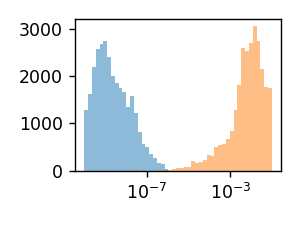

In [20]:
plot_diff(H_2_ao_contrib2, nd_H_1_ao_contrib2)

将动能与势能贡献相加和，就得到总的 Hamiltonian Core 的总二阶梯度 `H_2_ao` $h_{\mu \nu}^{A_t B_s}$ 了：

<IPython.core.display.Javascript object>


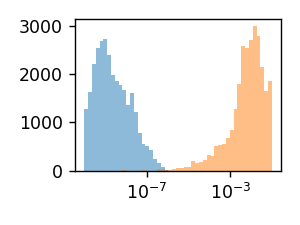

In [21]:
H_2_ao = H_2_ao_contrib1 + H_2_ao_contrib2
nd_H_1_ao = NumericDiff(gradn, lambda gradh: gradh.H_1_ao).derivative
plot_diff(H_2_ao, nd_H_1_ao)

在 pyxdh 中，它对应的是 `H_2_ao` property：

In [22]:
np.allclose(H_2_ao, hessh.H_2_ao)

True

在 PySCF 中，亦有 `hessian.rhf.hcore_generator` 可以生成 $h_{\mu \nu}^{A_t B_s}$：

In [23]:
np.allclose(
    H_2_ao,
    np.array([[hessian.RHF(gradh.scf_eng).hcore_generator()(A, B) for B in range(natm)] for A in range(natm)]).swapaxes(1, 2).reshape(natm * 3, natm * 3, nao, nao)
)

True

### `S_2_ao` $S_{\mu \nu}^{A_t B_s}$ 重叠积分二阶导数

我们回顾到

$$
S_{\mu \nu}^{A_t} = - \langle \partial_t \mu_A | \partial_s \nu \rangle + \mathrm{swap} (\mu, \nu)
$$

那么，通过链式法则可以轻松地推知

$$
S_{\mu \nu}^{A_t B_s} = \frac{\partial}{\partial B_s} S_{\mu \nu}^{A_t} = \langle \partial_t \mu_A | \partial_s \nu_B \rangle + \langle \partial_t \partial_s \mu_{AB} | \nu \rangle + \mathrm{swap} (\mu, \nu)
$$

在此之前，我们定义

- `int1e_ipovlpip` $\langle \partial_t \mu | \partial_s \nu \rangle$

- `int1e_ipovlpip` $\langle \partial_t \partial_s \mu | \nu \rangle$

In [24]:
int1e_ipovlpip = mol.intor("int1e_ipovlpip").reshape(3, 3, nao, nao)
int1e_ipovlpip.shape

(3, 3, 22, 22)

In [25]:
int1e_ipipovlp = mol.intor("int1e_ipipovlp").reshape(3, 3, nao, nao)
int1e_ipipovlp.shape

(3, 3, 22, 22)

In [26]:
S_2_ao = np.zeros((natm, 3, natm, 3, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    S_2_ao[A, :, A, :, sA, :] += int1e_ipipovlp[:, :, sA, :]
    for B in range(natm):
        sB = mol_slice(B)
        S_2_ao[A, :, B, :, sA, sB] += int1e_ipovlpip[:, :, sA, sB]
S_2_ao += S_2_ao.swapaxes(-1, -2)
S_2_ao.shape = (natm * 3, natm * 3, nao, nao)

我们可以用数值导数验证其正确性：

<IPython.core.display.Javascript object>


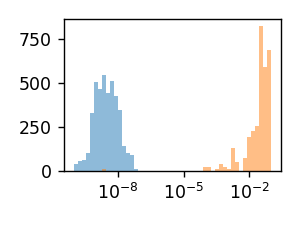

In [27]:
nd_S_1_ao = NumericDiff(gradn, lambda gradh: gradh.S_1_ao).derivative
plot_diff(S_2_ao, nd_S_1_ao)

在 pyxdh 中，$S_{\mu \nu}^{A_t B_s}$ 对应了 `S_2_ao` property：

In [28]:
np.allclose(S_2_ao, hessh.S_2_ao)

True

### `eri2_ao` $(\mu \nu | \kappa \lambda)^{A_t B_s}$ ERI 积分二阶导数

我们回顾到

$$
(\mu \nu | \kappa \lambda)^{A_t} = - (\partial_t \mu_A \nu | \kappa \lambda) + \mathrm{swap} (\mu, \nu) + \mathrm{swap} (\mu \nu, \kappa \lambda)
$$

我们知道 $\partial_{B_s} (1/r) = 0$，即双电子积分的算符是不受原子核坐标变化而干扰的，那么很容易地可以通过链式法则，获得

$$
(\mu \nu | \kappa \lambda)^{A_t} = \frac{1}{2} (\partial_t \partial_s \mu_{AB} \nu | \kappa \lambda) + \frac{1}{2} (\partial_t \mu_A \partial_s \nu_B | \kappa \lambda) + (\partial_t \mu_A \nu | \partial_s \kappa_B \lambda) + \mathrm{swap} (\mu, \nu) + \mathrm{swap} (\kappa, \lambda) + \mathrm{swap} (\mu \nu, \kappa \lambda)
$$

上式借用了下述结论：

$$
(\partial_t \mu_A \nu | \partial_s \kappa_B \lambda) + (\partial_t \mu_A \nu | \kappa \partial_s \lambda_B) = (\partial_t \mu_A \nu | \partial_s \kappa_B \lambda) + \mathrm{swap} (\kappa, \lambda)
$$

我们可以额外定义下述变量：

- `int2e_ipip1` $(\partial_t \partial_s \mu \nu | \kappa \lambda)$

- `int2e_ipvip1` $(\partial_t \mu \partial_s \nu | \kappa \lambda)$

- `int2e_ip1ip2` $(\partial_t \mu \nu | \partial_s \kappa \lambda)$

In [29]:
int2e_ipip1 = mol.intor("int2e_ipip1").reshape(3, 3, nao, nao, nao, nao)
int2e_ipvip1 = mol.intor("int2e_ipvip1").reshape(3, 3, nao, nao, nao, nao)
int2e_ip1ip2 = mol.intor("int2e_ip1ip2").reshape(3, 3, nao, nao, nao, nao)

In [30]:
eri2_ao = np.zeros((natm, 3, natm, 3, nao, nao, nao, nao))
for A in range(natm):
    sA = mol_slice(A)
    eri2_ao[A, :, A, :, sA, :, :, :] += 0.5 * int2e_ipip1[:, :, sA, :, :, :]
    for B in range(natm):
        sB = mol_slice(B)
        eri2_ao[A, :, B, :, sA, sB, :, :] += 0.5 * int2e_ipvip1[:, :, sA, sB, :, :]
        eri2_ao[A, :, B, :, sA, :, sB, :] += int2e_ip1ip2[:, :, sA, :, sB, :]
eri2_ao += eri2_ao.swapaxes(-3, -4)
eri2_ao += eri2_ao.swapaxes(-1, -2)
eri2_ao += eri2_ao.swapaxes(-1, -3).swapaxes(-2, -4)
eri2_ao.shape = (natm * 3, natm * 3, nao, nao, nao, nao)

我们可以用数值导数验证其正确性：

<IPython.core.display.Javascript object>


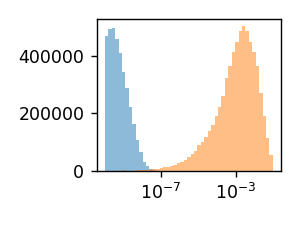

In [31]:
nd_eri1_ao = NumericDiff(gradn, lambda gradh: gradh.eri1_ao).derivative
plot_diff(eri2_ao, nd_eri1_ao)

### `E_2_nuc` $\partial_{A_t} \partial_{B_s} E_\mathrm{nuc}$ 核互斥能二阶导数

我们回顾到

$$
\begin{align}
\partial_{A_t} E_\mathrm{nuc} &= - Z_{AM} r_{AM}^{-3} V_{AMt} \\
Z_{MN} &= Z_M Z_N \\
V_{MNt} &= M_t - N_t \\
r_{MN}^{-1} &= \left\{
\begin{matrix}
| \boldsymbol{M} - \boldsymbol{N} |^{-1}, & \quad M \neq N \\
0, & \quad M = N
\end{matrix}
\right.
\end{align}
$$

我们在推导核互斥能一阶梯度时，上述的三个变量都是在已经导出了梯度表达式之后，处于简化的目的而定义的变量。我们下面补充两个性质：

$$
\begin{align}
\partial_{A_t} V_{MNr} &= \delta_{AM} \delta_{tr} - \delta_{AN} \delta_{tr} \\
\partial_{A_t} r_{MN}^{-1} &= - r_{MN}^{-3} V_{MNt} (\delta_{MA} - \delta_{NA})
\end{align}
$$

我们补充定义变量：

- `nuc_Z` $Z_{MN}$

- `nuc_V` $V_{MNt}$

- `nuc_rinv` $r_{MN}^{-1}$

In [32]:
nuc_Z = np.einsum("A, B -> AB", mol.atom_charges(), mol.atom_charges())
nuc_V = lib.direct_sum("Mt - Nt -> MNt", mol.atom_coords(), mol.atom_coords())
nuc_rinv = 1 / (np.linalg.norm(nuc_V, axis=2) + np.diag([np.inf] * natm))

- `delta_AB` $\delta_{AB}$

- `delta_ts` $\delta_{ts}$

In [33]:
delta_AB = np.eye(natm)
delta_ts = np.eye(3)

我们应当能推知

$$
\partial_{A_t} \partial_{B_s} E_\mathrm{nuc} = - Z_{AM} r_{AM}^{-3} \delta_{AB} \delta_{ts} + Z_{AB} r_{AB}^{-3} \delta_{ts} + 3 Z_{AM} r_{AM}^{-5} V_{AMt} V_{AMs} \delta_{AB} - 3 Z_{AB} r_{AB}^{-5} V_{ABt} V_{ABs}
$$

In [34]:
E_2_nuc = (
    - np.einsum("AM, AM, AB, ts -> AtBs", nuc_Z, nuc_rinv**3, delta_AB, delta_ts)
    + np.einsum("AB, AB, ts -> AtBs", nuc_Z, nuc_rinv**3, delta_ts)
    + 3 * np.einsum("AM, AM, AMt, AMs, AB -> AtBs", nuc_Z, nuc_rinv**5, nuc_V, nuc_V, delta_AB)
    - 3 * np.einsum("AB, AB, ABt, ABs -> AtBs", nuc_Z, nuc_rinv**5, nuc_V, nuc_V)
)
E_2_nuc.shape = (natm * 3, natm * 3)

我们可以与数值导数进行验证：

<IPython.core.display.Javascript object>


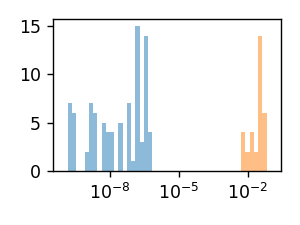

In [35]:
nd_E_1_nuc = NumericDiff(gradn, lambda gradh: gradh.scf_grad.grad_nuc()).derivative
plot_diff(E_2_nuc, nd_E_1_nuc)

在 PySCF 中可以导出解析二阶梯度，我们用下述代码验证之：

In [36]:
np.allclose(
    E_2_nuc,
    hessian.RHF(gradh.scf_eng).hess_nuc().swapaxes(1, 2).reshape((12, 12))
)

True